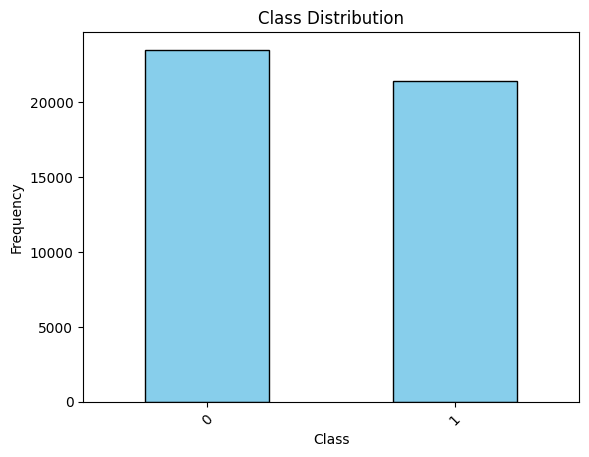

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 44919/44919 [33:44<00:00, 22.19it/s]


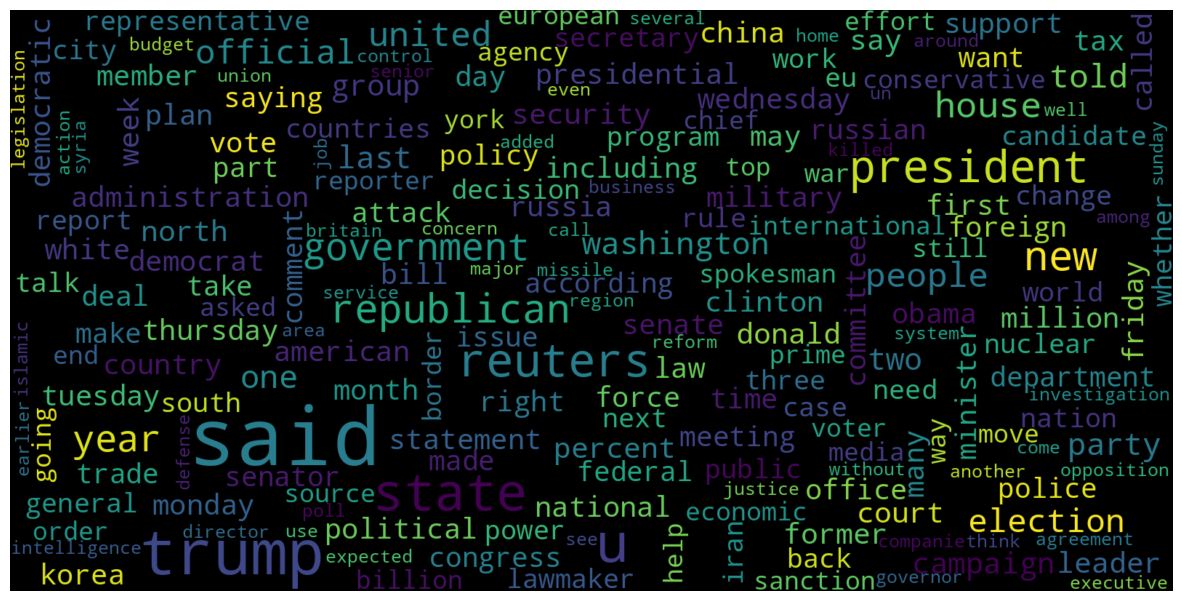

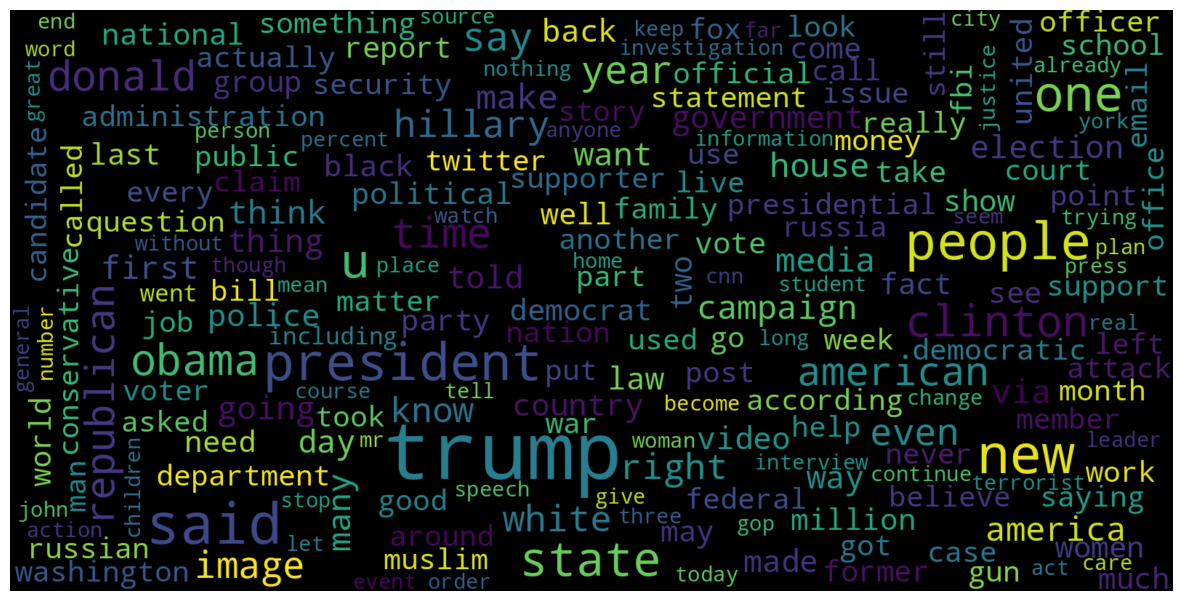

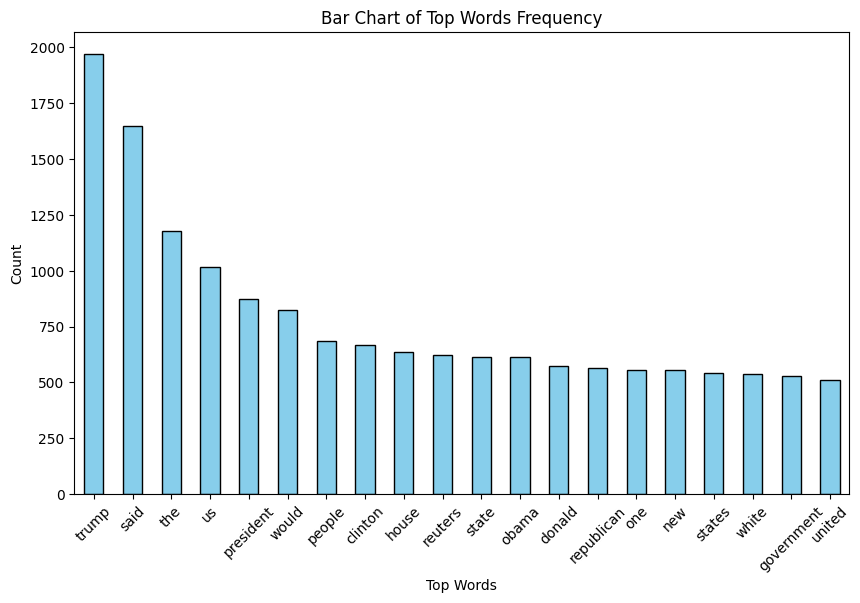

Logistic Regression Train accuracy: 0.9934993618094927
Logistic Regression Test accuracy: 0.9888691006233303
Decision Tree Train accuracy: 0.9999703167205913
Decision Tree Test accuracy: 0.9963490650044523


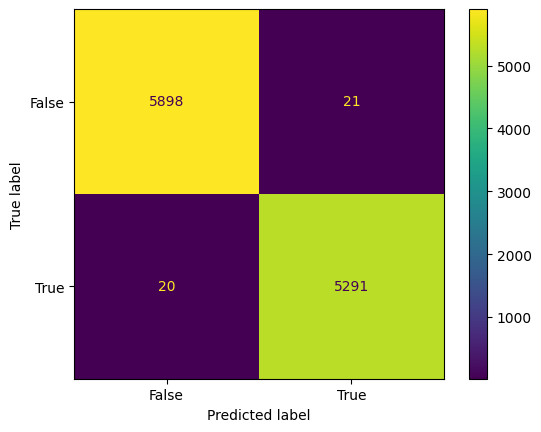

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import tqdm
import wordcloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import re

# Load data
data = pd.read_csv('/News.csv', index_col=0)
data.head()

# Get the shape of the data
data.shape

# Dropping unnecessary columns
data = data.drop(["title", "subject", "date"], axis=1)

# Checking for missing values
data.isnull().sum()

# Shuffling data
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

# Countplot replacement with Matplotlib
class_counts = data['class'].value_counts()
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# NLTK setup
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
from wordcloud import WordCloud

# Preprocessing function for text data
def preprocess_text(text_data):
    preprocessed_text = []
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                          for token in str(sentence).split()
                                          if token not in stopwords.words('english')))
    return preprocessed_text

# Preprocess the 'text' column in the DataFrame
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

# Real class word cloud generation
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 1].astype(str))

# WordCloud setup and generation
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)

# Plotting the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

# Fake news word cloud generation
consolidated_fake = ' '.join(
    word for word in data['text'][data['class'] == 0].astype(str))

wordCloud_fake = WordCloud(width=1600,
                           height=800,
                           random_state=21,
                           max_font_size=110,
                           collocations=False)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud_fake.generate(consolidated_fake), interpolation='bilinear')
plt.axis('off')
plt.show()

# Get the top N words using CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 20 words
common_words = get_top_n_words(data['text'], 20)

# Create a DataFrame
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

# Plot using Matplotlib
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    color='skyblue',
    edgecolor='black'
)

plt.xlabel("Top Words")
plt.ylabel("Count")
plt.title("Bar Chart of Top Words Frequency")
plt.xticks(rotation=45)
plt.show()

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['class'], test_size=0.25)

# Initialize the TfidfVectorizer
vectorization = TfidfVectorizer()

# Fit and transform the training data, and transform the test data
x_train_tfidf = vectorization.fit_transform(x_train)
x_test_tfidf = vectorization.transform(x_test)

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(x_train_tfidf, y_train)

# Testing the model's accuracy on train and test data
print("Logistic Regression Train accuracy:", accuracy_score(y_train, logreg_model.predict(x_train_tfidf)))
print("Logistic Regression Test accuracy:", accuracy_score(y_test, logreg_model.predict(x_test_tfidf)))

# Initialize and train the Decision Tree model
tree_model = DecisionTreeClassifier()
tree_model.fit(x_train_tfidf, y_train)

# Testing the model's accuracy on train and test data
print("Decision Tree Train accuracy:", accuracy_score(y_train, tree_model.predict(x_train_tfidf)))
print("Decision Tree Test accuracy:", accuracy_score(y_test, tree_model.predict(x_test_tfidf)))

# Generate confusion matrix for Decision Tree
cm = confusion_matrix(y_test, tree_model.predict(x_test_tfidf))

# Display confusion matrix using ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()

# Show the plot
plt.show()
